In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 800
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 20000

IMPROVED_W_LR = 1e-4
IMPROVED_W_EPOCH = 256

ITEMS_PER_FILE = 2000

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPUs


## Load in the image data

In [3]:
img_names = []

for i in range(1,202600):
    img_name = str(i)
    pad_zero = str(0)*(6-len(img_name))
    img_name = pad_zero + img_name + '.png'
    img_names.append(img_name)


In [4]:
DATA_PATH = './img_align_celeba_png/'

def load_img(img_name):
    raw_img = tf.io.read_file(DATA_PATH + img_name)
    return raw_img

## Write TFRecord

In [5]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [6]:
def serialize_example(img):
    feature = {
        'img': _bytes_feature(img)
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [7]:
def tf_serialize_example(img):
    tf_string = tf.py_function(
        serialize_example,
        [img],
        tf.string)
    return tf.reshape(tf_string, ())

In [8]:
num=0
for i in range(0,len(img_names),ITEMS_PER_FILE):
    raw_image_data = tf.data.Dataset.from_tensor_slices(img_names[i:i+ITEMS_PER_FILE])
    raw_image_data = raw_image_data.map(load_img,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = raw_image_data.map(tf_serialize_example,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filename = f'train_{num:03d}_.tfrecord'
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialized_features_dataset)
    num+=1


## Reading TFRecord

In [4]:
def processing(raw_img):
    img = tf.image.decode_png(raw_img, channels=3)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img,tf.float32)
    img = img / 255.
    return img

In [5]:
filename_list = []
for i in range(102):
    filename_list.append(f'train_{i:03d}_.tfrecord')
raw_dataset_train = tf.data.TFRecordDataset(filename_list)
raw_dataset_train

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [6]:
feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed['img']

In [7]:
parsed_dataset_train = raw_dataset_train.map(_parse_function)
dsTrain = parsed_dataset_train.map(processing)
dsTrain = dsTrain.shuffle(BUF)

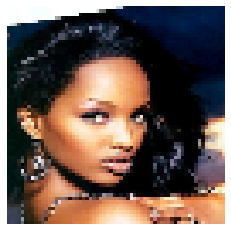

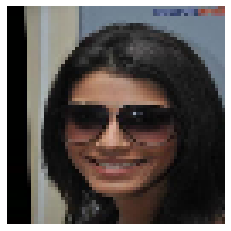

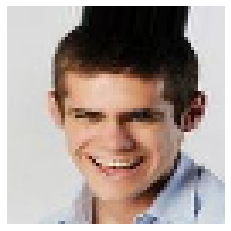

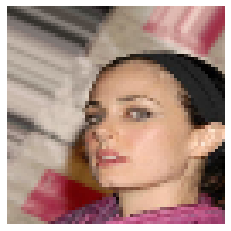

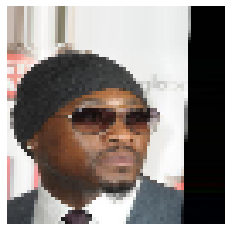

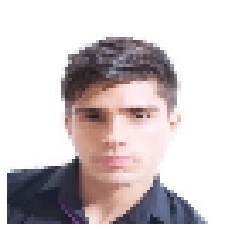

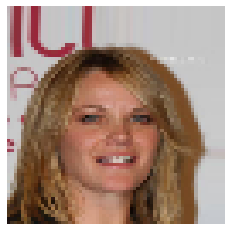

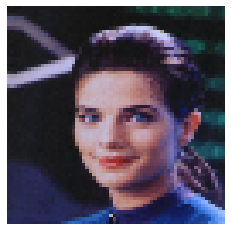

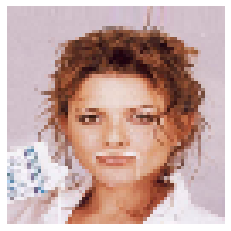

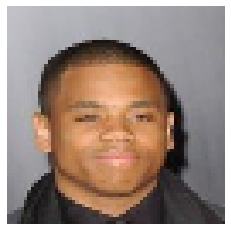

In [8]:
number_of_img = 0
for img in dsTrain:
    if number_of_img == 10:
        break
    plt.imshow(img.numpy())
    plt.axis("off")
    plt.show()
    number_of_img+=1

In [9]:
dsTrain = dsTrain.batch(BATCH_SIZE,drop_remainder=True)
dsTrain = dsTrain.prefetch(500)

## Utility function

In [4]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

## GAN model

In [11]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [12]:
IMPROVED_WG, IMPROVED_WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(learning_rate=IMPROVED_W_LR,beta_1=0.,beta_2=0.9)
optimizer_d = keras.optimizers.Adam(learning_rate=IMPROVED_W_LR,beta_1=0.,beta_2=0.9)

In [13]:
@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)
    with tf.GradientTape() as tpg:
        with tf.GradientTape() as tp_gradientpenalty:
            x_bar = IMPROVED_WG(z, training = True)

            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            z1 = IMPROVED_WD(x, training = True)
            z0 = IMPROVED_WD(x_bar, training = True)
            penalty = IMPROVED_WD(x_hat, training = True)
            gradient_penalty = tp_gradientpenalty.gradient(penalty,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_g = tpg.gradient(lg, IMPROVED_WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, IMPROVED_WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)
    with tf.GradientTape() as tpd:
        with tf.GradientTape() as tp_gradientpenalty:
            x_bar = IMPROVED_WG(z, training = True)

            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            z1 = IMPROVED_WD(x, training = True)
            z0 = IMPROVED_WD(x_bar, training = True)
            penalty = IMPROVED_WD(x_hat, training = True)
            gradient_penalty = tp_gradientpenalty.gradient(penalty,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_d = tpd.gradient(ld, IMPROVED_WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, IMPROVED_WD.trainable_variables))
    
    return lg, ld

In [14]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

In [15]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(IMPROVED_WG = IMPROVED_WG,
                           IMPROVED_WD = IMPROVED_WD,
                           optimizer_g = optimizer_g,
                           optimizer_d = optimizer_d)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [ ]:
wlg = [None] * IMPROVED_W_EPOCH #record loss of g for each epoch
wld = [None] * IMPROVED_W_EPOCH #record loss of d for each epoch
wsp = [None] * IMPROVED_W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(img_names))
ctr = 0
for ep in range(IMPROVED_W_EPOCH):
    print("Epoch: " + str(ep+1), end='\r')
    lgt = 0.0
    ldt = 0.0
    for idx, c1 in enumerate(dsTrain):
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    with open('./wlg.txt','a') as f:
        f.write(str(lgt * rsTrain) + '\n')
    f.close()
    with open('./wld.txt','a') as f:
        f.write(str(ldt * rsTrain) + '\n')
    f.close()
    
    out = IMPROVED_WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 10 == 0: 
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % (ep+1))
        plt.show()
    if (ep+1) % 10 == 0: 
        ckpt_manager.save()

## Generate GIF 

In [9]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

def load_gan_img(path):
    image = load_img(path)
    data = img_to_array(image).astype(np.uint8)
    return data

In [10]:
img_gan_gen = load_gan_img('./imgs/w_0250.png')
print(type(img_gan_gen))

<class 'numpy.ndarray'>


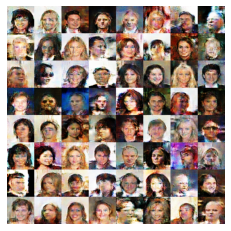

In [11]:
plt.imshow(img_gan_gen)
plt.axis("off")
plt.show()

In [12]:
output_img = []
for i in range(0,255,5):
    output_img.append(load_gan_img('imgs/w_%04d.png' % i))
output_img.append(load_gan_img('imgs/w_%04d.png' % 250))

In [14]:
utMakeGif(np.array(output_img), "imgs/wgan.gif", duration = 2)

t:   4%|▍         | 2/52 [00:00<00:04, 12.44it/s, now=None]

MoviePy - Building file imgs/wgan.gif with imageio.


## Show the GIF

![SegmentLocal](submission_imgs/wgan.gif "segment")

In the GIF, we can see how the model generate the pictures stroke by stroke. It first draw the outline of the faces, and then modify and sharpen the details.

## Show some samples

In [138]:
def get_img_from_puzzle(row, col, path=None,output_num=0):
    puzzle = load_img(path)
    puzzle = img_to_array(puzzle).astype(np.uint8)
    h, w, c = (IMG_H,IMG_W,IMG_C)
    img = puzzle[row * h : (row + 1) * h, col * w : (col + 1) * w, :]
    img = img_to_array(img).astype(np.uint8)
    imageio.imwrite('submission_imgs/'+ str(output_num) + '_'+ path.split('/')[1], img)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

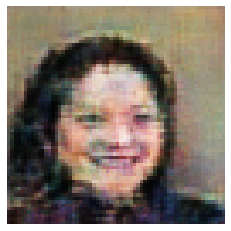

In [139]:
get_img_from_puzzle(2,5,'imgs/w_0255.png',0)

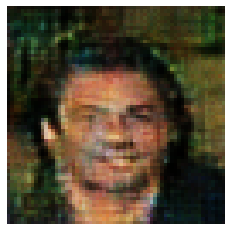

In [140]:
get_img_from_puzzle(3,5,'imgs/w_0255.png',1)

## Draw the training curves

In [132]:
wld = []
wlg = []
with open('./wld.txt') as f:
    lines = f.readlines()
    f.close()
for line in lines:
    wld.append(float(line.strip('\n')))
    
with open('./wlg.txt') as f:
    lines = f.readlines()
    f.close()
for line in lines:
    wlg.append(float(line.strip('\n')))

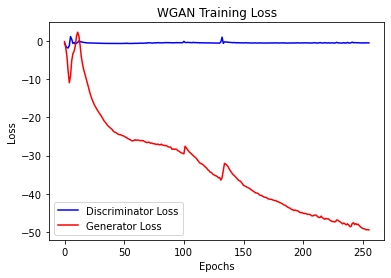

In [135]:
plt.plot(range(IMPROVED_W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(IMPROVED_W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "lower left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

## Report

In this lab I do the following things.

#### Turn the training data into tf_record files

To speed up the training process, I first turn the image data into tf_record files, and in the training process, I just read those tf_record files for training.

#### Tune the parameter of Adam optimizer

I use the parameters show in the paper. For learninig rate, I use 1e-4, for beta_1 I use 0, for beta_2 I use 0.9

#### Implement improved wgan

When calculating the loss of discriminator, I first generate the random embedding, z. Then input z into the generator, get a batch of images. I name those images x_bar.

Later, I generate epsilon, which is from uniform distribution 0~1. I get x_hat by doing the calculation:

_x\_hat = epsilon * x + (1.-epsilon) * x\_bar_

Where x is the ground truth images

Then, I send the x, x_bar, x_hat into discriminator.

I calculate the L2 norm of the discriminator, whose input is x_hat, and then calculate gradient of the L2 norm. 

Then, I subtract 1 from the gradient, and squared it, to gain the gradient_penalty.

Finally, I calculate the mean of D(x_bar) - D(x) + 10*gradient_penalty, where D means the discriminator.

When calculating the loss of generator, I just add minus on the D(x_bar), and calculate the mean of it.

#### Review

I think this lab is hard to train, and I get some kind of frustrated. But at least, I think the gif file shows that the model is improving the outputs to make them looks more real.